# MinHash signatures are fun!

In [1]:
%matplotlib inline
import numpy
import scipy
import pylab
import scipy.cluster.hierarchy as sch

In [2]:
def load_matrix_and_labels(basefile):
    D = numpy.load(open(basefile, 'rb'))
    labeltext = [ x.strip() for x in open(basefile + '.labels.txt') ]
    return (D, labeltext)

def plot_composite_matrix(D, labeltext, show_labels=True, show_indices=True):
    if show_labels:
        show_indices=True
    D = numpy.array(D, copy=True)

    fig = pylab.figure(figsize=(11,8))
    ax1 = fig.add_axes([0.09,0.1,0.2,0.6])

    # plot denderogram
    Y = sch.linkage(D, method='single') # centroid  
    
    dendrolabels = labeltext
    if not show_labels:
        dendrolabels = [ str(i) for i in range(len(labeltext)) ]
                        
    Z1 = sch.dendrogram(Y, orientation='right', labels=dendrolabels,
                        no_labels=not show_indices)
    ax1.set_xticks([])

    xstart = 0.45
    width = 0.45
    if not show_labels:
        xstart = 0.315
    scale_xstart = xstart + width + 0.01

    # plot matrix
    axmatrix = fig.add_axes([xstart,0.1, width,0.6])

    # (this reorders D by the clustering in Z1)
    idx1 = Z1['leaves']
    D = D[idx1, :]
    D = D[:, idx1]

    # show matrix
    im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu, vmin=0, vmax=1)
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.                                                            
    axcolor = fig.add_axes([scale_xstart,0.1,0.02,0.6])
    pylab.colorbar(im, cax=axcolor)
    
    # print labels, if not shown
    if not show_labels:
        for i, label in enumerate(labeltext):
            print('%d\t%s' % (i, label))

    return fig

## Error trimming helps

Conclusion: removing low-abundance k-mers from raw reads yields better clusters.

In [3]:
!sourmash compare SRR2*.sig -o trim.npy > /dev/null && echo success || echo fail

# running sourmash subcommand: compare
loading SRR2060939_1.fastq.gz.sig
loading SRR2060939_1.fastq.gz.trimnoV.fq.gz.sig
loading SRR2060939_2.fastq.gz.sig
loading SRR2060939_2.fastq.gz.trimnoV.fq.gz.sig
loading SRR2241509_1.fastq.gz.sig
loading SRR2241509_1.fastq.gz.trimnoV.fq.gz.sig
loading SRR2255622_1.fastq.gz.sig
loading SRR2255622_1.fastq.gz.trimnoV.fq.gz.sig
min similarity in matrix: 0.0120000001043
saving labels to: trim.npy.labels.txt
saving distance matrix to: trim.npy
success


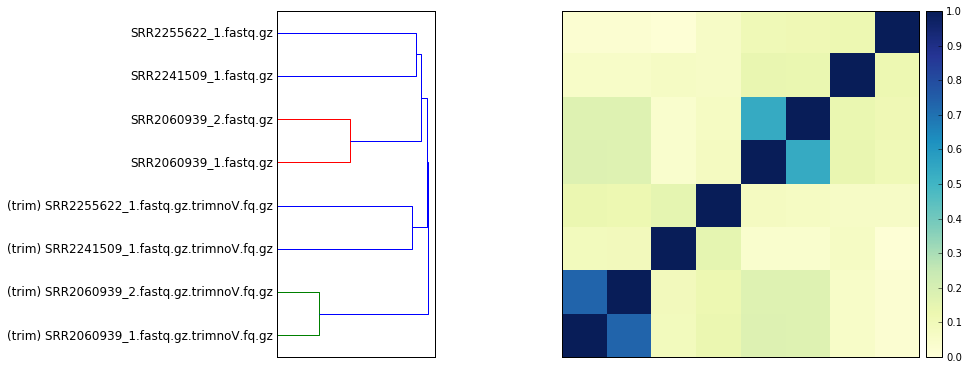

In [4]:
D_filename = 'trim.npy'

D, labeltext = load_matrix_and_labels(D_filename)

# relabel the trimmed ones as 'trim' - they're the ones with trim in the filename ;)
for i in range(len(labeltext)):
    if i % 2:
        labeltext[i] = '(trim) '+ labeltext[i]
_ = plot_composite_matrix(D, labeltext)
pylab.savefig('sourmash-trimming.png')

In [5]:
print(labeltext)

['SRR2060939_1.fastq.gz', '(trim) SRR2060939_1.fastq.gz.trimnoV.fq.gz', 'SRR2060939_2.fastq.gz', '(trim) SRR2060939_2.fastq.gz.trimnoV.fq.gz', 'SRR2241509_1.fastq.gz', '(trim) SRR2241509_1.fastq.gz.trimnoV.fq.gz', 'SRR2255622_1.fastq.gz', '(trim) SRR2255622_1.fastq.gz.trimnoV.fq.gz']


## Comparing 200+ echinoderm data sets

Conclusion: echinoderm data sets cluster almost entirely by species, with little to no cross-species similarity.

In [6]:
!sourmash compare urchin/*.sig -o urchin.npy > /dev/null && echo success || echo fail

# running sourmash subcommand: compare
loading urchin/abyssicola-SRR3217899.sig
loading urchin/agassizii-SRR1695485.sig
loading urchin/amurensis-SRR1139201.sig
loading urchin/amurensis-SRR1141046.sig
loading urchin/amurensis-SRR1642063.sig
loading urchin/angulata-SRR3217897.sig
loading urchin/annulatus-SRR1695480.sig
loading urchin/annulatus-SRR1695481.sig
loading urchin/bispinosus-SRR3217921.sig
loading urchin/brevispina-SRR2845428.sig
loading urchin/briareus-SRR1139189.sig
loading urchin/californicus-SRR1139198.sig
loading urchin/californicus-SRR1695477.sig
loading urchin/chloroticus-SRR1014618.sig
loading urchin/chloroticus-SRR1014619.sig
loading urchin/chloroticus-SRR1014624.sig
loading urchin/chloroticus-SRR1014627.sig
loading urchin/chloroticus-SRR1014631.sig
loading urchin/chloroticus-SRR1014633.sig
loading urchin/chloroticus-SRR1205884.sig
loading urchin/chloroticus-SRR1205886.sig
loading urchin/chloroticus-SRR1205888.sig
loading urchin/chloroticus-SRR1205890.sig
loading urchin

In [7]:
%%capture
D_filename = 'urchin.npy'

D, labeltext = load_matrix_and_labels(D_filename)
fig = plot_composite_matrix(D, labeltext, show_labels=False, show_indices=False)
pylab.savefig('sourmash-urchin.png')

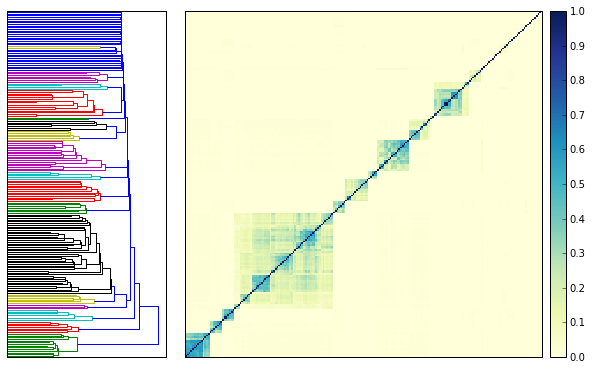

In [8]:
fig

## Comparing bat stars

Conclusion: Patiria asterina and Patiria pectinifera group together, agreeing with [recent reclassifications](https://en.wikipedia.org/wiki/Bat_star#Classification) (ht Dan Rokhsar).

In [9]:
!sourmash compare urchin/miniata*.sig urchin/pectinifera*.sig -o patiria.npy > /dev/null \
    && echo success || echo fail


# running sourmash subcommand: compare
loading urchin/miniata-SRR1138705.sig
loading urchin/miniata-SRR2454338.sig
loading urchin/miniata-SRR573675.sig
loading urchin/miniata-SRR573705.sig
loading urchin/miniata-SRR573706.sig
loading urchin/miniata-SRR573707.sig
loading urchin/miniata-SRR573708.sig
loading urchin/miniata-SRR573709.sig
loading urchin/miniata-SRR573710.sig
loading urchin/pectinifera-DRR023760.sig
loading urchin/pectinifera-DRR023761.sig
loading urchin/pectinifera-SRR1139200.sig
loading urchin/pectinifera-SRR1141045.sig
min similarity in matrix: 0.0719999969006
saving labels to: patiria.npy.labels.txt
saving distance matrix to: patiria.npy
success


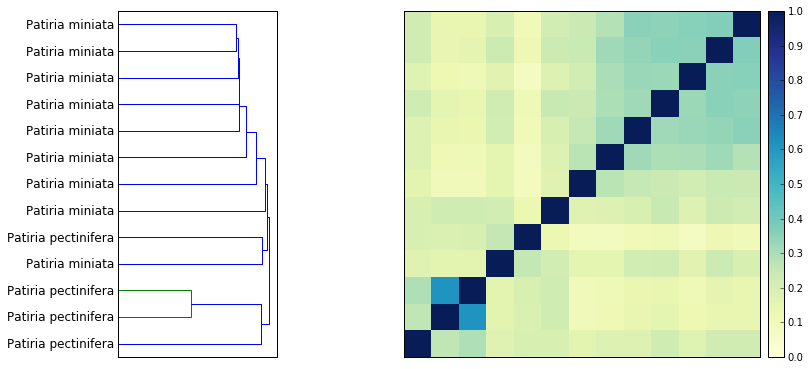

In [10]:
D_filename = 'patiria.npy'

D, labeltext = load_matrix_and_labels(D_filename)
fig = plot_composite_matrix(D, labeltext)
pylab.savefig('sourmash-patiria.png')